In [3]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# 1. Results B3.0
Evaluation of the annotations of the train set for task B3

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [4]:
#B1.0
path_B3 = 'STRING_RESULT_TRAIN/B3.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_7917.csv')


In [5]:
# Combine all dataframes into one
B3_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [6]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B3 = B3_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B3.shape

(5660, 6)

In [7]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B3['unique_id'].unique().tolist()

In [8]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [9]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score      support
egalitarian                   0.368421  0.571429  0.448000    49.000000
general normative statement   0.098131  0.636364  0.170040    33.000000
libertarian                   0.000000  0.000000  0.000000     1.000000
not evaluated                 0.984321  0.607527  0.751330   930.000000
prioritarian                  0.352941  0.677419  0.464088    62.000000
sufficientarian               0.357143  0.714286  0.476190     7.000000
utilitarian                   0.250000  0.660000  0.362637    50.000000
accuracy                      0.613074  0.613074  0.613074     0.613074
macro avg                     0.344422  0.552432  0.381755  1132.000000
weighted avg                  0.860063  0.613074  0.685988  1132.000000


Classification Report for S2
                             precision    recall  f1-score      support
egalitarian                   0.370370  0.612245  0.461538    49.000000
gene

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [11]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B3_consistency = filtered_B3.groupby('unique_id').filter(principle_y_not_uniform)

B3_consistency.shape

(855, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [12]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B3.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B3_grouped = filtered_B3.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B3_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,0,"Thank you, Mr. President .",not evaluated,"0 Thank you, Mr. President .\n",1,not evaluated
1,1,"On beha lf of the government of Japan , I wou...",not evaluated,"1 On beha lf of the government of Japan , I w...",1,not evaluated
2,2,I would also like to expr ess my d eepest con...,not evaluated,2 I would also like to expr ess my d eepest c...,1,not evaluated
3,3,Mr. President: A fair and effective framewor...,utilitarian,3 Mr. President: A fair and effective framew...,1,egalitarian
4,4,"In this regard, Japan firmly supports the est...",not evaluated,"4 In this regard, Japan firmly supports the e...",1,not evaluated
...,...,...,...,...,...,...
1127,1207,New Zealand is proud to suppor t several impo...,not evaluated,1207 New Zealand is proud to suppor t several...,1,not evaluated
1128,1208,"I am joined by New Zealand’s largest business,...",not evaluated,1208 I am joined by New Zealand’s largest busi...,1,not evaluated
1129,1209,The commitment o f New Zealanders from across ...,not evaluated,1209 The commitment o f New Zealanders from ac...,1,not evaluated
1130,1210,Thank you Mr President.,not evaluated,1210 Thank you Mr President.\n,1,not evaluated


In [13]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.39      0.61      0.48        49
general normative statement       0.10      0.64      0.17        33
                libertarian       0.00      0.00      0.00         1
              not evaluated       0.99      0.60      0.75       930
               prioritarian       0.35      0.66      0.46        62
            sufficientarian       0.36      0.71      0.48         7
                utilitarian       0.24      0.64      0.35        50

                   accuracy                           0.61      1132
                  macro avg       0.35      0.55      0.38      1132
               weighted avg       0.86      0.61      0.68      1132



(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'not evaluated'),
  Text(4, 0, 'prioritarian'),
  Text(5, 0, 'sufficientarian'),
  Text(6, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

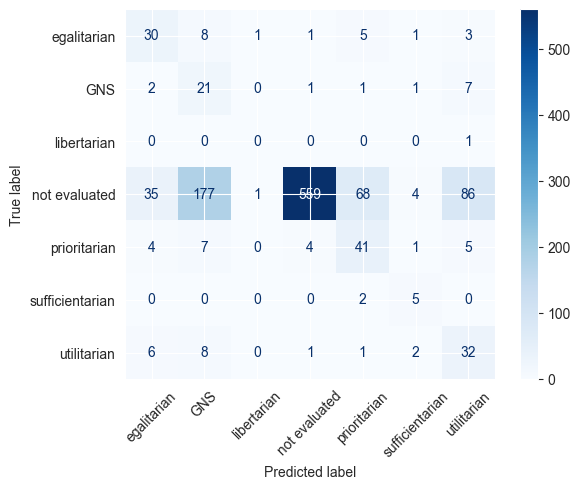

In [15]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian', 'not evaluated','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)

-------------------------------------------------------

# 2. Results B3.0.1

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [16]:
#B1.0
path_B3 = 'STRING_RESULT/B3.0.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_7917.csv')


In [17]:
# Combine all dataframes into one
B3_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [18]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B3 = B3_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B3.shape

(5340, 6)

In [19]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B3['unique_id'].unique().tolist()

In [20]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [21]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-sc

Classification Report for S1
                             precision    recall  f1-score      support
egalitarian                   0.288889  0.604651  0.390977    43.000000
general normative statement   0.093525  0.406250  0.152047    32.000000
libertarian                   0.000000  0.000000  0.000000     0.000000
not evaluated                 0.979817  0.614499  0.755304   869.000000
prioritarian                  0.279720  0.677966  0.396040    59.000000
sufficientarian               0.235294  0.500000  0.320000     8.000000
utilitarian                   0.233083  0.543860  0.326316    57.000000
accuracy                      0.606742  0.606742  0.606742     0.606742
macro avg                     0.301475  0.478175  0.334383  1068.000000
weighted avg                  0.841336  0.606742  0.676557  1068.000000


Classification Report for S2
                             precision    recall  f1-score      support
egalitarian                   0.295455  0.604651  0.396947    43.000000
gene

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [22]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B3_consistency = filtered_B3.groupby('unique_id').filter(principle_y_not_uniform)

B3_consistency.shape

(795, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [23]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B3.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B3_grouped = filtered_B3.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B3_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,0,"Thank you, Mr. President .",not evaluated,"0 Thank you, Mr. President .\n",1,not evaluated
1,1,"On beha lf of the government of Japan , I wou...",not evaluated,"1 On beha lf of the government of Japan , I w...",1,not evaluated
2,2,I would also like to expr ess my d eepest con...,not evaluated,2 I would also like to expr ess my d eepest c...,1,not evaluated
3,3,Mr. President: A fair and effective framewor...,utilitarian,3 Mr. President: A fair and effective framew...,1,egalitarian
4,4,"In this regard, Japan firmly supports the est...",not evaluated,"4 In this regard, Japan firmly supports the e...",1,not evaluated
...,...,...,...,...,...,...
1063,1207,New Zealand is proud to suppor t several impo...,not evaluated,1207 New Zealand is proud to suppor t several...,1,not evaluated
1064,1208,"I am joined by New Zealand’s largest business,...",not evaluated,1208 I am joined by New Zealand’s largest busi...,1,not evaluated
1065,1209,The commitment o f New Zealanders from across ...,not evaluated,1209 The commitment o f New Zealanders from ac...,1,not evaluated
1066,1210,Thank you Mr President.,not evaluated,1210 Thank you Mr President.\n,1,not evaluated


In [24]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.29      0.60      0.39        43
general normative statement       0.09      0.41      0.14        32
                libertarian       0.00      0.00      0.00         0
              not evaluated       0.98      0.61      0.75       869
               prioritarian       0.29      0.68      0.41        59
            sufficientarian       0.28      0.62      0.38         8
                utilitarian       0.25      0.58      0.35        57

                   accuracy                           0.60      1068
                  macro avg       0.31      0.50      0.35      1068
               weighted avg       0.84      0.60      0.67      1068



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'not evaluated'),
  Text(4, 0, 'prioritarian'),
  Text(5, 0, 'sufficientarian'),
  Text(6, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

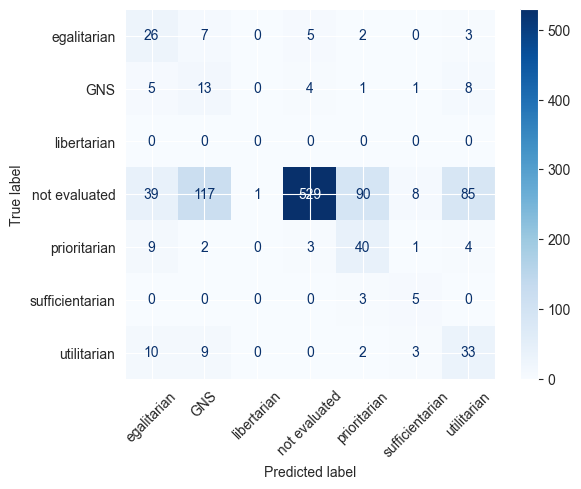

In [25]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian', 'not evaluated','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)

-------------------------------------------------------

# 3. Results B3.1

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [26]:
#B1.0
path_B3 = 'STRING_RESULT/B3.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_7917.csv')


In [32]:
# Remove principle prefix from S4
S4['PRINCIPLE_y'] = S4['PRINCIPLE_y'].str.replace('PRINCIPLE: ',"")

In [33]:
# Combine all dataframes into one
B3_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [34]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B3 = B3_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B3.shape

(5860, 6)

In [35]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B3['unique_id'].unique().tolist()

In [36]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [37]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score      support
egalitarian                   0.426667  0.615385  0.503937    52.000000
general normative statement   0.117904  0.794118  0.205323    34.000000
libertarian                   0.200000  1.000000  0.333333     1.000000
not evaluated                 0.992038  0.650993  0.786120   957.000000
prioritarian                  0.385965  0.676923  0.491620    65.000000
sufficientarian               0.454545  0.714286  0.555556     7.000000
utilitarian                   0.272727  0.535714  0.361446    56.000000
accuracy                      0.650171  0.650171  0.650171     0.650171
macro avg                     0.407121  0.712488  0.462476  1172.000000
weighted avg                  0.869725  0.650171  0.718363  1172.000000


Classification Report for S2
                             precision    recall  f1-score      support
egalitarian                   0.436620  0.596154  0.504065    52.000000
gene

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [38]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B3_consistency = filtered_B3.groupby('unique_id').filter(principle_y_not_uniform)

B3_consistency.shape

(650, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [39]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B3.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B3_grouped = filtered_B3.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B3_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,0,"Thank you, Mr. President .",not evaluated,"0 Thank you, Mr. President .\n",1,not evaluated
1,1,"On beha lf of the government of Japan , I wou...",not evaluated,"1 On beha lf of the government of Japan , I w...",1,not evaluated
2,2,I would also like to expr ess my d eepest con...,not evaluated,2 I would also like to expr ess my d eepest c...,1,not evaluated
3,3,Mr. President: A fair and effective framewor...,utilitarian,3 Mr. President: A fair and effective framew...,1,egalitarian
4,4,"In this regard, Japan firmly supports the est...",not evaluated,"4 In this regard, Japan firmly supports the e...",1,not evaluated
...,...,...,...,...,...,...
1167,1207,New Zealand is proud to suppor t several impo...,not evaluated,1207 New Zealand is proud to suppor t several...,1,not evaluated
1168,1208,"I am joined by New Zealand’s largest business,...",not evaluated,1208 I am joined by New Zealand’s largest busi...,1,not evaluated
1169,1209,The commitment o f New Zealanders from across ...,not evaluated,1209 The commitment o f New Zealanders from ac...,1,not evaluated
1170,1210,Thank you Mr President.,not evaluated,1210 Thank you Mr President.\n,1,not evaluated


In [40]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.41      0.60      0.48        52
general normative statement       0.11      0.76      0.19        34
                libertarian       0.20      1.00      0.33         1
              not evaluated       0.99      0.65      0.78       957
               prioritarian       0.38      0.62      0.47        65
            sufficientarian       0.46      0.86      0.60         7
                utilitarian       0.28      0.54      0.36        56

                   accuracy                           0.64      1172
                  macro avg       0.40      0.72      0.46      1172
               weighted avg       0.87      0.64      0.71      1172



(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'not evaluated'),
  Text(4, 0, 'prioritarian'),
  Text(5, 0, 'sufficientarian'),
  Text(6, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

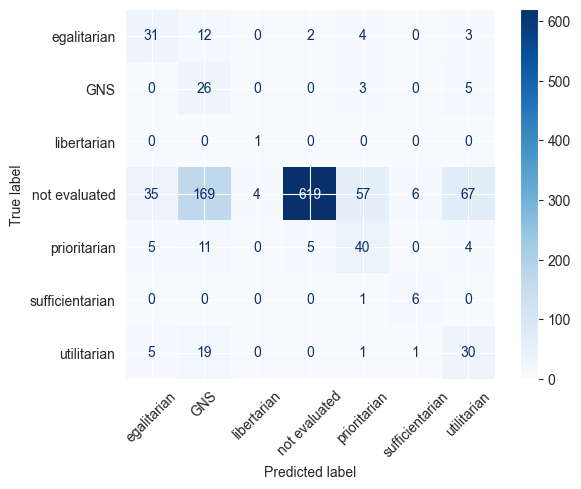

In [41]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian', 'not evaluated','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)

# 4. Results B3.1.1

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [42]:
#B1.0
path_B3 = 'STRING_RESULT/B3.1.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B3}/all_iterations_string_T0_7917.csv')


In [43]:
# Remove principle prefix from S4
S4['PRINCIPLE_y'] = S4['PRINCIPLE_y'].str.replace('PRINCIPLE: ',"")

In [44]:
# Combine all dataframes into one
B3_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [45]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B3 = B3_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B3.shape

(4160, 6)

In [46]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B3['unique_id'].unique().tolist()

In [47]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [48]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S2 = generate_classification_report(FB1S2, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S3 = generate_classification_report(FB1S3, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S4 = generate_classification_report(FB1S4, 'PRINCIPLE_x', 'PRINCIPLE_y')
report_S5 = generate_classification_report(FB1S5, 'PRINCIPLE_x', 'PRINCIPLE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                             precision    recall  f1-score     support
egalitarian                   0.377358  0.645161  0.476190   31.000000
general normative statement   0.125828  0.703704  0.213483   27.000000
libertarian                   0.000000  0.000000  0.000000    0.000000
not evaluated                 0.982906  0.675477  0.800696  681.000000
prioritarian                  0.333333  0.530612  0.409449   49.000000
sufficientarian               0.300000  0.600000  0.400000    5.000000
utilitarian                   0.357143  0.641026  0.458716   39.000000
accuracy                      0.664663  0.664663  0.664663    0.664663
macro avg                     0.353795  0.542283  0.394076  832.000000
weighted avg                  0.860837  0.664663  0.728069  832.000000


Classification Report for S2
                             precision    recall  f1-score     support
egalitarian                   0.392157  0.645161  0.487805   31.000000
general normative

C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-sc

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [49]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
def principle_y_not_uniform(group):
    return group['PRINCIPLE_y'].nunique() != 1


# Group by 'ID' and filter groups
B3_consistency = filtered_B3.groupby('unique_id').filter(principle_y_not_uniform)

B3_consistency.shape

(465, 6)


In combined dataframe, groupyby unique ID and take the majority label

In [50]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B3.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'PRINCIPLE_y']}
agg_dict['PRINCIPLE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B3_grouped = filtered_B3.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B3_grouped

,unique_id,text,PRINCIPLE_x,llm_query,iteration,PRINCIPLE_y
0,20,Japan will establish a low carbon society thr...,not evaluated,20 Japan will establish a low carbon society ...,1,not evaluated
1,21,We will strategically promote mitigation meas...,not evaluated,21 We will strategically promote mitigation m...,1,not evaluated
2,22,We will enhance development and demonstration...,not evaluated,22 We will enhance development and demonstrat...,1,not evaluated
3,23,Japan is hosting the IPCC session next March.,not evaluated,23 Japan is hosting the IPCC session next Mar...,1,not evaluated
4,24,"Using that opportunity, we will launch a new ...",not evaluated,"24 Using that opportunity, we will launch a n...",1,not evaluated
...,...,...,...,...,...,...
827,1207,New Zealand is proud to suppor t several impo...,not evaluated,1207 New Zealand is proud to suppor t several...,1,not evaluated
828,1208,"I am joined by New Zealand’s largest business,...",not evaluated,1208 I am joined by New Zealand’s largest busi...,1,not evaluated
829,1209,The commitment o f New Zealanders from across ...,not evaluated,1209 The commitment o f New Zealanders from ac...,1,not evaluated
830,1210,Thank you Mr President.,not evaluated,1210 Thank you Mr President.\n,1,not evaluated


In [51]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.38      0.65      0.48        31
general normative statement       0.13      0.70      0.22        27
                libertarian       0.00      0.00      0.00         0
              not evaluated       0.98      0.68      0.80       681
               prioritarian       0.30      0.49      0.37        49
            sufficientarian       0.25      0.60      0.35         5
                utilitarian       0.37      0.67      0.48        39

                   accuracy                           0.66       832
                  macro avg       0.34      0.54      0.39       832
               weighted avg       0.86      0.66      0.73       832



C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\App\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'egalitarian'),
  Text(1, 0, 'GNS'),
  Text(2, 0, 'libertarian'),
  Text(3, 0, 'not evaluated'),
  Text(4, 0, 'prioritarian'),
  Text(5, 0, 'sufficientarian'),
  Text(6, 0, 'utilitarian')])

<Figure size 8000x8000 with 0 Axes>

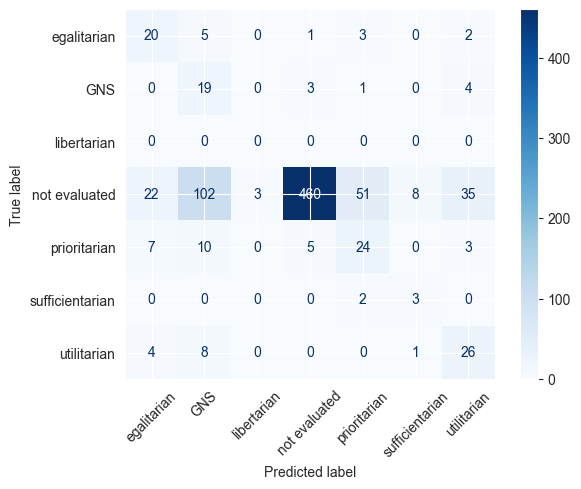

In [52]:
# Evaluate confusionmatrix for this aggregated set
labels = ['egalitarian', 'GNS', 'libertarian', 'not evaluated','prioritarian', 'sufficientarian', 'utilitarian']

plt.figure(figsize=(80, 80))
cm = confusion_matrix(filtered_B3_grouped['PRINCIPLE_x'],filtered_B3_grouped['PRINCIPLE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis and y-axis tick labels
plt.xticks(rotation=45)